In [ ]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from utils.DataUtils import DataUtils

data_utils= DataUtils()

# 加载数据集
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
eval_dataset = MNIST(root='./data', train=False, download=True, transform=transform)

print(f"训练集的数据个数: {len(train_dataset)}")
print(f"验证集的数据个数: {len(eval_dataset)}")

In [ ]:
# 查看数据集的样例

data_utils.show_image_simple(train_dataset,count=4)

In [ ]:
# 模型组网

import torch
from model.BetaScheduler import LinearBetaScheduler
from model.UNet import UNet
from model.CD_Model import CD_Model
from utils.CDModelWorker import CDModelWorker
from torchkeras import summary

input_shape=data_utils.get_data_shape(train_dataset)

model=CD_Model(
    UNet(
        input_shape=input_shape,
        num_classes=10,
        init_features=64,
        embed_dim=128
    ),
    LinearBetaScheduler()
)

model_worker=CDModelWorker(model)

print(f"{input_shape=}")

time=torch.Tensor([0])
condition=torch.Tensor([0])
model_info=summary(model,input_shape=input_shape,time=time,condition=condition)

In [3]:
# 模型准备
from torch.utils.data import DataLoader
from torch import nn
from torch import optim

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
eval_loader = DataLoader(eval_dataset, batch_size=64)

loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
# 模型训练

model_worker.train(
    criterion=loss,
    optimizer=optimizer,
    train_loader=train_loader,
    # eval_loader=eval_loader,
    epochs=10,
)

In [ ]:
# 模型评估

model_worker.evaluate(
    eval_loader=eval_loader,
    criterion=loss,
)

In [5]:
# 保存模型
model_worker.save('./output/CD_model.pth')

In [4]:
# 加载模型
model_worker.load('./output/CD_model.pth')

In [23]:
datas=model_worker.generate_sample(count=4,condition=9,add_noise=True)

Sampling: 100%|██████████| 1000/1000 [00:08<00:00, 118.38step/s]


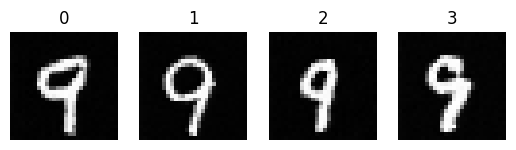

In [24]:
datas=datas.cpu()
data_utils.show_image_batch(datas)